In [1]:
import torch
from torch import nn
import pathlib
from pathlib import Path
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from torchvision import datasets, transforms


In [2]:
class PathMNISTModel1(nn.Module):
  def __init__(self,):
    super().__init__()
    #Make a CNN here
    self.block1 = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size= 2, stride = 2),)
    self.block2 = nn.Sequential(
      nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = 2, stride = 2),
    )
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(10*16*16, 128),
      nn.ReLU(),
      nn.Linear(128, 10)
    )

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x) 
    x = self.classifier(x)
    return x

In [3]:
data_path = Path('./data')
image_path = data_path / 'images'
all_image_paths = list(image_path.glob('*/*/*.jpg'))
train_dir = image_path / "Training"
test_dir = image_path / "Testing"
device = device = 'cuda' if torch.cuda.is_available() else 'cpu'
transform_image = transforms.Compose([
transforms.Resize((64, 64)),
transforms.Grayscale(3),
transforms.ToTensor(),
#transforms.Normalize(mean=[(-1.3080 + -1.2077 + -0.9801)/3], std=[(0.8160 + 0.8342 + 0.8305/3)])
])



In [4]:
train_data = datasets.ImageFolder(
    root=train_dir,
    transform=transform_image,
)

test_data = datasets.ImageFolder(
    root=test_dir,
    transform=transform_image,
)

classes = {
    0 : 'Glioma',
    1 : 'Meningioma',
    2 : 'No Tumour Detected!',
    3 : 'Pituitary Cancer',
}

In [5]:
def random_image_test(saved_model_path, test_data):
    loaded_model = PathMNISTModel1()
    loaded_model.load_state_dict(torch.load(f'ModelSaver/{saved_model_path}'))
    loaded_model.eval()
    randidx = np.random.randint(0, len(test_data))
    with torch.no_grad():
        image, answer = test_data[randidx]
        image = image.to(device)  # Move image to the same device as the model
        num_guess = loaded_model(image.unsqueeze(0)).argmax(1)
        pic = Image.open(all_image_paths[randidx])
        ans = test_data.classes[answer]
        ithink = test_data.classes[num_guess.item()]
        plt.imshow(pic)  # Move image back to CPU for plotting
        plt.axis('off')
        yes = 'g' if answer == num_guess.item() else 'r'
        plt.title(f'Actual Answer: {ans}, Guess is {ithink}', c=yes)

In [6]:
def random_image_test_2(saved_model_path, test_data):
    loaded_model = PathMNISTModel1()
    loaded_model.load_state_dict(torch.load(f'ModelSaver/{saved_model_path}'))
    loaded_model.eval()
    randidx = np.random.randint(0, len(test_data))
    with torch.no_grad():
        image, answer = test_data[randidx]
        image = image.to(device)  # Move image to the same device as the model
        guess = loaded_model(image.unsqueeze(0))
        num_guess = guess.argmax(1)
        total_guess = guess.softmax(1).max(1)[0].item()
        pic = Image.open(all_image_paths[randidx])
        ans = test_data.classes[answer]
        ithink = test_data.classes[num_guess.item()]
        plt.imshow(pic)  # Move image back to CPU for plotting
        plt.axis('off')
        yes = 'g' if answer == num_guess.item() else 'r'
        plt.title(f'Actual Answer: {ans}, Guess is {ithink} \n with {(total_guess*100):.2f}% certainity', c=yes)

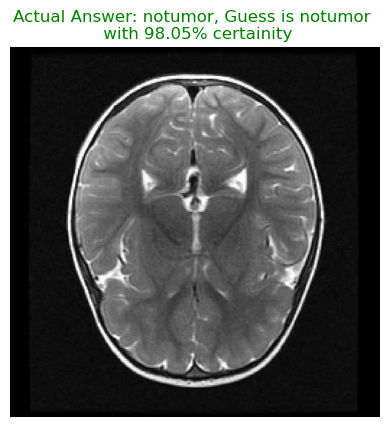

In [7]:
random_image_test_2('NoNormal10Epoch.pth', test_data)

In [8]:
def image_test(saved_model_path, image):
    loaded_model = PathMNISTModel1()
    loaded_model.load_state_dict(torch.load(f'ModelSaver/{saved_model_path}'))
    loaded_model.eval()
    with torch.no_grad(): # Move image to the same device as the model
        guess = loaded_model(image.unsqueeze(0))
        num_guess = guess.argmax(1)
        percentage = (guess.softmax(1).max(1)[0].item())*100
        ithink = classes[num_guess.item()]
        return ithink, percentage

In [10]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk

# Initialize the main window
root = tk.Tk()
root.title("Concept MRI Image Classification")
root.geometry("800x600")
root.configure(bg='#1f1f1f')  # Set background color

# Define colors based on the theme from the image
bg_color = "#1f1f1f"  # Dark background color
sidebar_color = "#333"  # Sidebar color
text_color = "white"  # White text color
button_color = "#4CAF50"  # Button color (greenish)
button_text_color = "white"  # Button text color

# Sidebar Frame (left section)
sidebar_frame = tk.Frame(root, bg=sidebar_color, width=200)
sidebar_frame.pack(side="left", fill="y")

# Main Content Frame (right section)
content_frame = tk.Frame(root, bg=bg_color)
content_frame.pack(side="left", fill="both", expand=True, padx=20, pady=20)

# Function to open file explorer and display the selected image
def open_file():
    file_path = filedialog.askopenfilename(
        filetypes=[("Image Files", "*.png;*.jpg;*.jpeg;*.gif;*.bmp")]
    )
    if file_path:
        img = Image.open(file_path)
        image = transform_image(img)
        answer, percentage = image_test('NoNormal10Epoch.pth', image)
        content_label.config(text=f"The closest guess is {answer} \n with {percentage: .2f}% confidence")
        img = img.resize((300, 300)) # Resize the image to fit the placeholder
        img = ImageTk.PhotoImage(img)
        image_placeholder.config(image=img)
        image_placeholder.image = img  # Keep a reference to avoid garbage collection

# Add a button to the sidebar
sidebar_button = tk.Button(sidebar_frame, text="Open Image", bg=button_color, fg=button_text_color, font=("Helvetica Neue", 12), relief="flat", command=open_file)
sidebar_button.pack(pady=20, padx=20)

# Add some text in the content frame
content_label = tk.Label(content_frame, text="Let AI guess", bg=bg_color, fg=text_color, font=("Helvetica Neue", 16))
content_label.pack(pady=10)

# Placeholder for an image in the content frame
image_placeholder = tk.Label(content_frame, text="Scan will be displayed here", bg=bg_color, fg=text_color, font=("Helvetica Neue", 14), relief="solid")
image_placeholder.pack(pady=20)

# Run the application
root.mainloop()
